In [1]:
#!pip3 install neat-python

from keras.datasets import mnist
import numpy as np
import ssl
import neat
from skimage.transform import rescale
import matplotlib.pyplot as plt

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    # Legacy Python that doesn't verify HTTPS certificates by default
    pass
else:
    # Handle target environment that doesn't support HTTPS verification
    ssl._create_default_https_context = _create_unverified_https_context

Using TensorFlow backend.
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/tensorflow/python/framework/dtypes.py:463: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/tensorflow/python/framework/dtypes.py:464: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/tensorflow/python/framework/dtypes.py:465: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([(

## Global Parameters

In [2]:
# Dataset parameters
STANDARD_IMAGE_SIZE = 28
DESIRED_IMAGE_SIZE = 16
N_CLASSES_TO_USE = 4

RESCALE_FACTOR = DESIRED_IMAGE_SIZE/STANDARD_IMAGE_SIZE
N_PIXELS = DESIRED_IMAGE_SIZE**2

# How many samples to test:
N_SAMPLES_TO_TEST = 100

# Simulation Parameters
NR_GENERATIONS = 50

## Load MNIST

In [3]:
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

## Preprocess MNIST

### Trim down Dataset

In [4]:
# Ensure correct number of classes
X_train = X_train[Y_train < N_CLASSES_TO_USE]
Y_train = Y_train[Y_train < N_CLASSES_TO_USE]
X_test = X_test[Y_test < N_CLASSES_TO_USE]
Y_test = Y_test[Y_test < N_CLASSES_TO_USE]

# Extract and print the number of training and testing samples remaining
n_samples_train = X_train.shape[0]
n_samples_test = X_test.shape[0]
print(f"Training samples remaining: {n_samples_train}")
print(f"Testing samples remaining: {n_samples_test}")

Training samples remaining: 24754
Testing samples remaining: 4157


### Rescale Images

In [5]:
# Rescaling to the desired size
def rescale_images(images, do_anti_aliasing=False):
    return np.array([rescale(image, RESCALE_FACTOR, anti_aliasing=do_anti_aliasing) for image in images])

# Rescale X_train and X_test
X_train_small = rescale_images(X_train)
X_test_small = rescale_images(X_test)

### Normalize

In [6]:
# Normalize the data
def normalize(images):
    return (images - np.mean(images, axis=0))/(np.std(images, axis=0) + 0.000001)

# Normalize X_train_small and X_test_small
X_train_norm = normalize(X_train_small)
X_test_norm = normalize(X_test_small)

### Visualize

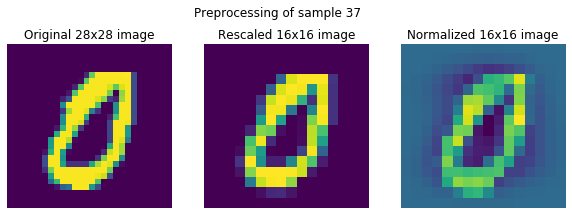

In [7]:
# Plot original and reshaped image
def plot_comparison(idx_to_plot, lists, titles):
    n_plots = len(lists)
    fig, ax = plt.subplots(1,n_plots, figsize=(10,10/n_plots))
    for i in range(n_plots):
        ax[i].imshow(lists[i][idx_to_plot])
        ax[i].set_title(titles[i])
        ax[i].axis("off")
    fig.suptitle(f"Preprocessing of sample {idx_to_plot}",y=1)
    plt.show()
    
plot_comparison(37,
                [X_train, X_train_small, X_train_norm],
                [f"Original {STANDARD_IMAGE_SIZE}x{STANDARD_IMAGE_SIZE} image",
                 f"Rescaled {DESIRED_IMAGE_SIZE}x{DESIRED_IMAGE_SIZE} image",
                 f"Normalized {DESIRED_IMAGE_SIZE}x{DESIRED_IMAGE_SIZE} image"])

In [8]:
# Replace and reshape X_train and X_test, for convenience
X_train = X_train_norm.reshape(n_samples_train, DESIRED_IMAGE_SIZE**2)
X_test = X_test_norm.reshape(n_samples_test, DESIRED_IMAGE_SIZE**2)

# NEAT

## Basic Run Function

In [9]:
def run(config_file):
    # Load configuration.
    config = neat.Config(neat.DefaultGenome, neat.DefaultReproduction,
                         neat.DefaultSpeciesSet, neat.DefaultStagnation,
                         config_file)

    # Create the population, which is the top-level object for a NEAT run.
    p = neat.Population(config)
    print(p)
    # Add a stdout reporter to show progress in the terminal.
    p.add_reporter(neat.StdOutReporter(True))
    stats = neat.StatisticsReporter()
    p.add_reporter(stats)
    p.add_reporter(neat.Checkpointer(5, filename_prefix='NEAT-checkpoints/neat-checkpoint-'))

    
    # Run for up to 50 generations.
    winner = p.run(eval_genomes, NR_GENERATIONS)

    # Display the winning genome.
    print('\nBest genome:\n{!s}'.format(winner))

    # Show output of the most fit genome against training data.
    print('\nOutput:')
    winner_net = neat.nn.FeedForwardNetwork.create(winner, config)


## Basic Evaluation Function

In [10]:
def eval_genomes(genomes, config):
    
    sample_indices = []
    n_samples_per_class = int(N_SAMPLES_TO_TEST/N_CLASSES_TO_USE)
    for c in range(N_CLASSES_TO_USE):
        c_indices = np.where(Y_train == c)[0]
        assert len(c_indices) >= n_samples_per_class, \
            f"Class {c} has too few elements to reach the desired number of evaluation samples"
        sample_indices.extend(np.random.permutation(c_indices)[:n_samples_per_class])
    
    # Compute cross-entropy loss for each of the samples
    losses = []
    for i in sample_indices:
        X_sample, Y_sample = X_train[i], Y_train[i]
        
    
    for genome_id, genome in genomes:
        genome.fitness = 0.
        net = neat.nn.FeedForwardNetwork.create(genome, config)
        nr_correct = 0.
        for i in sample_indices:
            train, label = X_train[i], Y_train[i]
            output = net.activate(train)
            if np.argmax(output) == label:
                nr_correct += 1.
        genome.fitness = (nr_correct / N_SAMPLES_TO_TEST)          
        
#  OLD FITNESS:
#         for i in sample_indices:
#             train, label = X_train[i], Y_train[i]
#             output = net.activate(train)
#             genome.fitness -= (np.argmax(output) - label) ** 2 
 

In [11]:
run('config-feedforward-weight-agnostic')


 ****** Running generation 0 ****** 

Population's average fitness: 0.26053 stdev: 0.01570
Best fitness: 0.29000 - size: (4, 1024) - species 1 - id 45
Average adjusted fitness: 0.021
Mean genetic distance 0.581, standard deviation 0.172
Population of 150 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1    0   150      0.3    0.021     0
Total extinctions: 0
Generation time: 5.582 sec

 ****** Running generation 1 ****** 

Population's average fitness: 0.26280 stdev: 0.03096
Best fitness: 0.32000 - size: (4, 1016) - species 1 - id 248
Average adjusted fitness: 0.073
Mean genetic distance 0.619, standard deviation 0.176
Population of 150 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1    1   150      0.3    0.073     0
Total extinctions: 0
Generation time: 5.545 sec (5.564 average)

 ****** Running generation 2 ****** 

Population's average fitness: 0.27773 st

Population's average fitness: 0.34067 stdev: 0.02424
Best fitness: 0.40000 - size: (6, 931) - species 1 - id 2642
Average adjusted fitness: 0.061
Mean genetic distance 0.895, standard deviation 0.231
Population of 150 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   17   150      0.4    0.061     6
Total extinctions: 0
Generation time: 5.070 sec (5.405 average)

 ****** Running generation 18 ****** 

Population's average fitness: 0.39427 stdev: 0.01923
Best fitness: 0.44000 - size: (5, 922) - species 1 - id 2697
Average adjusted fitness: 0.074
Mean genetic distance 0.799, standard deviation 0.202
Population of 150 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   18   150      0.4    0.074     7
Total extinctions: 0
Generation time: 5.113 sec (5.360 average)

 ****** Running generation 19 ****** 

Population's average fitness: 0.31780 stdev: 0.02181
Best fi

Population's average fitness: 0.40233 stdev: 0.02054
Best fitness: 0.47000 - size: (5, 851) - species 1 - id 5101
Average adjusted fitness: 0.062
Mean genetic distance 0.923, standard deviation 0.293
Population of 150 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   34   150      0.5    0.062     2
Total extinctions: 0
Generation time: 5.025 sec (4.989 average)
Saving checkpoint to NEAT-checkpoints/neat-checkpoint-34

 ****** Running generation 35 ****** 

Population's average fitness: 0.45313 stdev: 0.02101
Best fitness: 0.52000 - size: (4, 841) - species 1 - id 5232
Average adjusted fitness: 0.063
Mean genetic distance 1.027, standard deviation 0.286
Population of 150 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   35   150      0.5    0.063     0
Total extinctions: 0
Generation time: 6.879 sec (5.175 average)

 ****** Running generation 36 ****** 

Pop